# Importing libraries

In [ ]:
import os
import json
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from sklearn.metrics import recall_score

from utils.inference import *
from utils.metrics import *

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

# Specifying trained model

In [5]:
EXP_NAME = 'a2a122e4-c9bb-41c2-9c5e-2e70160e6419'

with open(f'experiments/{EXP_NAME}/config.json') as json_file:
    config = json.load(json_file)

config = edict(config)

os.makedirs(f'experiments/{EXP_NAME}/top_10_masks')

In [6]:
data_dict = {}
for subject in config.subjects:
    
    prediction_path = f"experiments/{config.EXP_NAME}/interpolation/{subject}.nii" 
    label_path = f"{config.path_to_data}/labels/{subject}.nii" 
    
    data_dict[subject] = [prediction_path, label_path]

In [7]:
df = pd.DataFrame(columns=['dice', 'iou', 'contrast', 'recall', 'top10', 'min_number_of_crops'])

for subject in tqdm(config.subjects):
    
    prediction_path, label_path = data_dict[subject]
    
    prediction = load_nii_to_array(prediction_path)
    label = load_nii_to_array(label_path)
    
    dice, iou, contrast, recall = compute_metrics_on_voxels(prediction, label)
    top10, min_number_of_crops = get_top_10_metric_and_mask(config, subject, prediction, label, crop_size=64)
    
    df.loc[subject] = [dice, iou, contrast, recall, np.round(top10, decimals=2), min_number_of_crops]
    
df.sort_values(by=['top10', 'contrast'], ascending=False, inplace=True)
df.loc['mean'] = df.mean()
df = df[['contrast', 'recall', 'top10', 'min_number_of_crops', 'dice', 'iou']]
df.to_csv(f'experiments/{EXP_NAME}/vb_metrics.csv')

100%|██████████| 80/80 [10:11<00:00,  7.64s/it]


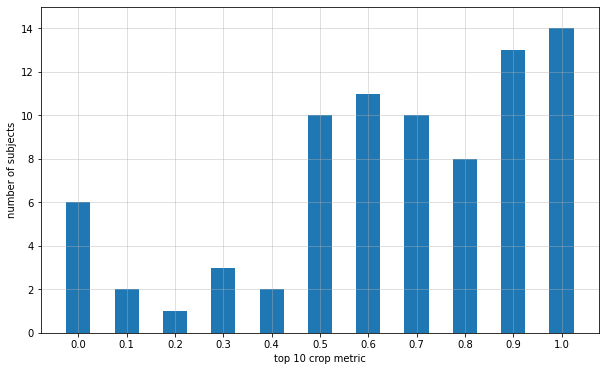

In [8]:
df_metric = pd.DataFrame(df.top10[:-1].value_counts())

fig, axs =  plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})

plt.bar(df_metric.index.tolist(),
        df_metric.top10.tolist(),
        width = 0.05,
       tick_label=df_metric.index.tolist())
plt.grid(True, alpha=0.5)
plt.ylim(0, max(df_metric.top10.tolist())+1)
plt.ylabel('number of subjects')
plt.xlabel('top 10 crop metric')
plt.savefig(f'experiments/{EXP_NAME}/vb_histogram_top_10_score.jpeg')